The code includes the details of how **symmetric and row-normalized operators** have been implemented into the GCN model.

Our experiment has been conducted under python 3.8.8

* **pytorch** 1.10
* **pytorch geometric** 2.0.5


## Load Required Packages

In [1]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
# visualizer and helper
from utils.helper import *
from utils.visualization import *

In [3]:
# import trainers and operators
from train import *
from operators import *

## II. Experiments on Simplified Model

### a. Cora

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='Planetoid', name='Cora', transform=NormalizeFeatures())
###
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
cora = dataset[0]  # Get the first graph object.



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [5]:
from torch.nn import Linear

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5,  gnn_type="normal", alpha=0, 
                 add_self_loops= True,
                 seed = 12345,
                 bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels[0],  
                             gnn_type = gnn_type,
                             alpha = alpha,
                            add_self_loops = add_self_loops,
                            bias = bias)
        self.conv2 = GCNConv(hidden_channels[0], dataset.num_classes,
                            gnn_type = gnn_type,
                            alpha = alpha,
                            add_self_loops = add_self_loops,
                            bias = bias)
   
        self.p = dropout_rate
        self.gnn_type = gnn_type 
        self.alpha = alpha
        self.seed = seed
        self.add_self_loops = add_self_loops = add_self_loops

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        h = x
#         x = x.relu()
#         x = self.lin1(x)
        return x, h

model = GCN(hidden_channels=[32])
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)


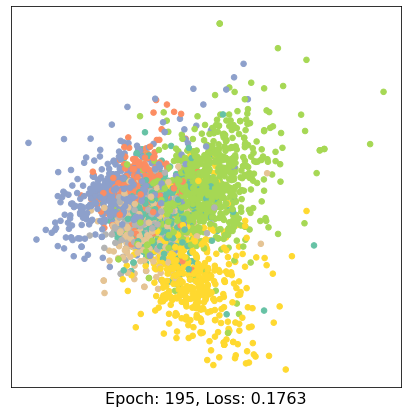

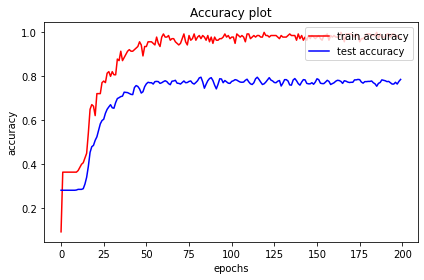

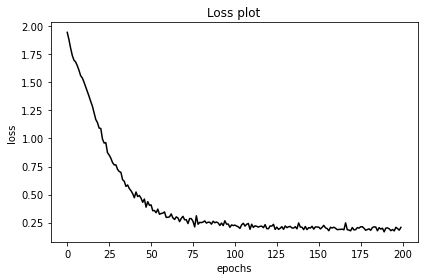

Final test accuracy: 0.79
Time to run function 'train': 13.57 seconds


In [12]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
training_set = np.random.choice(np.arange(data.num_nodes), 140)
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
alpha = 0.5
model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=alpha, 
                        seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(200, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [ ]:
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
n_exp = 50
results = {}

for i in np.arange(n_exp):
    seed = i
    training_set = np.random.choice(np.arange(data.num_nodes), 140)
    idx = torch.randperm(data.train_mask.shape[0])
    train_mask = data.train_mask[idx].view(data.train_mask.size())
    test_mask = ~train_mask
    idx2  =  (torch.where(test_mask)[0]).numpy()
    np.random.shuffle(idx2)
    test_mask[idx2[n_test:]] = False
    
    
    #### First model
    model = GCN(hidden_channels=[32], gnn_type = 'no', 
                        alpha=0.03, seed = np.random.choice(np.arange(10000)), bias = False)
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay
    train_acc_list, test_acc_list, loss_list, _,  _, out_temp = train(200, model, criterion, optimizer, 
                                                     x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                   test_mask),
                                                    scatter_size=30, plotting=False)
    results["Cora_no" +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                'test_acc': test_acc_list[-1],
                                 'seed' : model.seed,
                                'gnn_type': "no",
                                'embedding' : out_temp,
                                'exp number': i,
                                'alpha': 0,
                                'add_self_loop' : True,
                                'dataset' : 'Cora'}
    for experiment in ["normal", "diffusion"]:
        for alpha in np.arange(0,1.1,0.1):
            for loop in [True, False]:
                model = GCN(hidden_channels=[32], gnn_type = experiment, alpha=alpha, add_self_loops=loop,
                        seed = seed, bias = bias)
                criterion = torch.nn.CrossEntropyLoss() 
                optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4) #didn't include weight decay

                train_acc_list, test_acc_list, loss_list, _,  _, out_temp = train(200, model, criterion, optimizer, 
                                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                       test_mask),
                                                        scatter_size=30, plotting=False)
                results['Cora_' + experiment + '_' + str(alpha)+ '_loop_' + str(loop) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                             'test_acc': test_acc_list[-1],
                                             'seed' : model.seed,
                                             'gnn_type': experiment,
                                             'embedding' : out_temp,
                                             'exp number': i,
                                            'alpha': alpha,
                                            'add_self_loop' : loop,
                                            'dataset' : 'Cora'}   
                print(experiment + '_' + str(alpha)+ '_loop_' + str(loop) +'_bias_'+str(bias)+ '_' +  str(i) )


# IV. Visualize

## (a) Boxplot

In [4]:
import pickle
with open('training_results/result_cora.pkl', 'rb') as fr:
    results = pickle.load(fr)

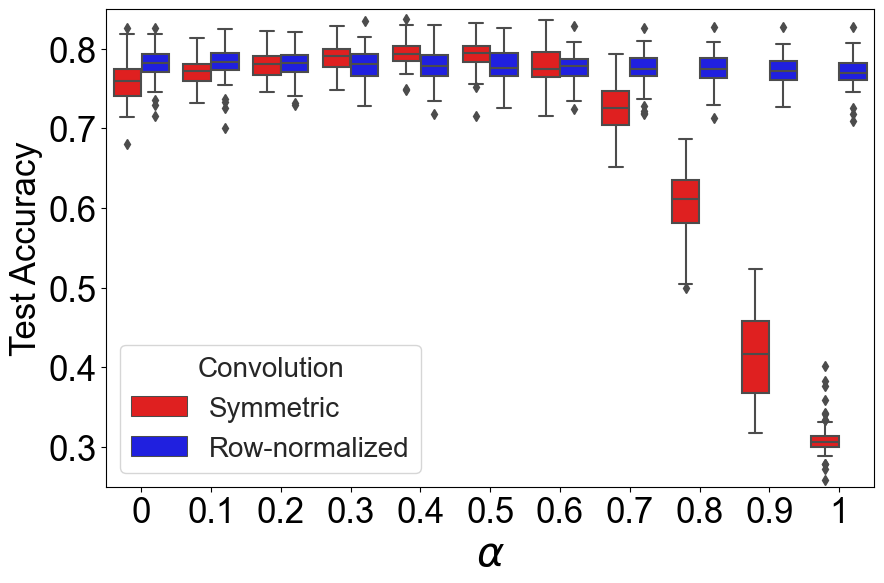

In [7]:
tight_acc_plot(results, name = 'cora_accuracy.png',interval=[0.25,0.85],symm =False)

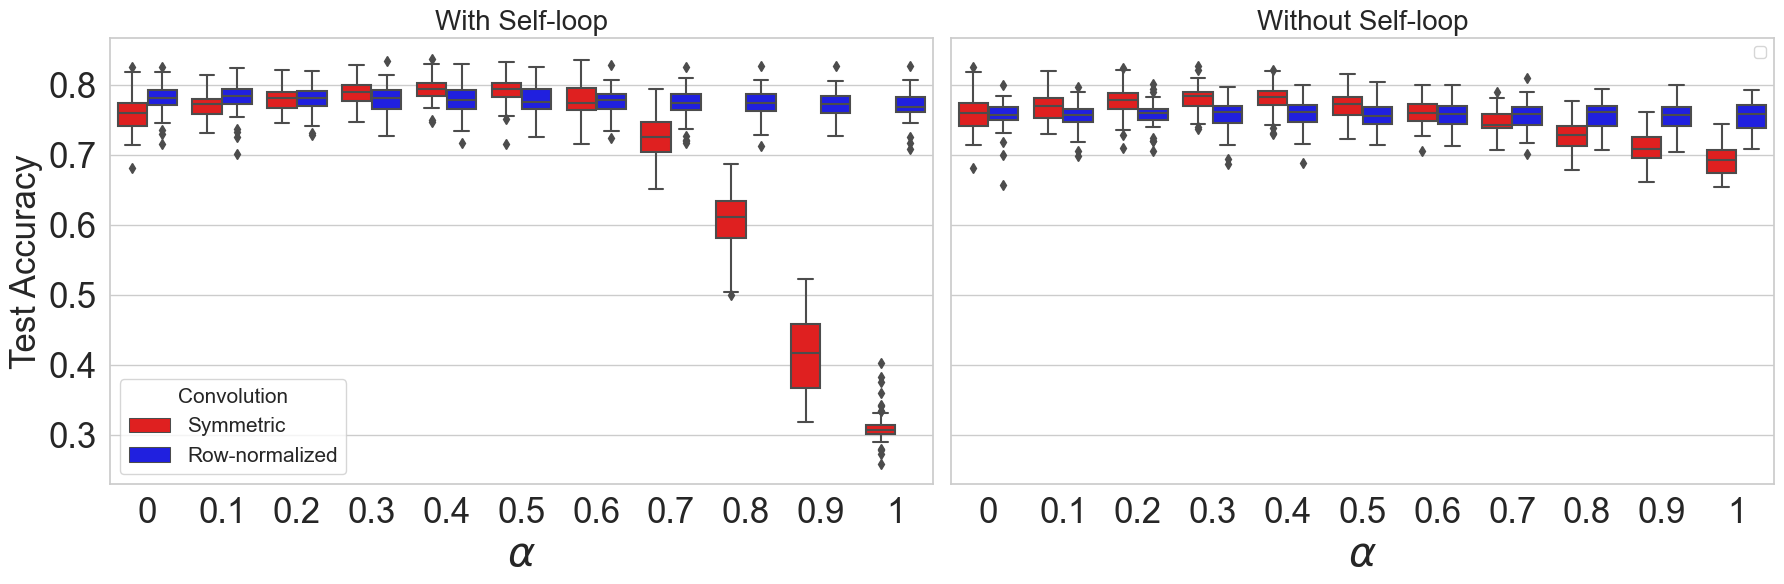

In [8]:
tight_acc_plot(results, name = 'cora_accuracy.png',interval=[0.25,0.85],multiple = True)

## (b) Embedding Spaces -- degree

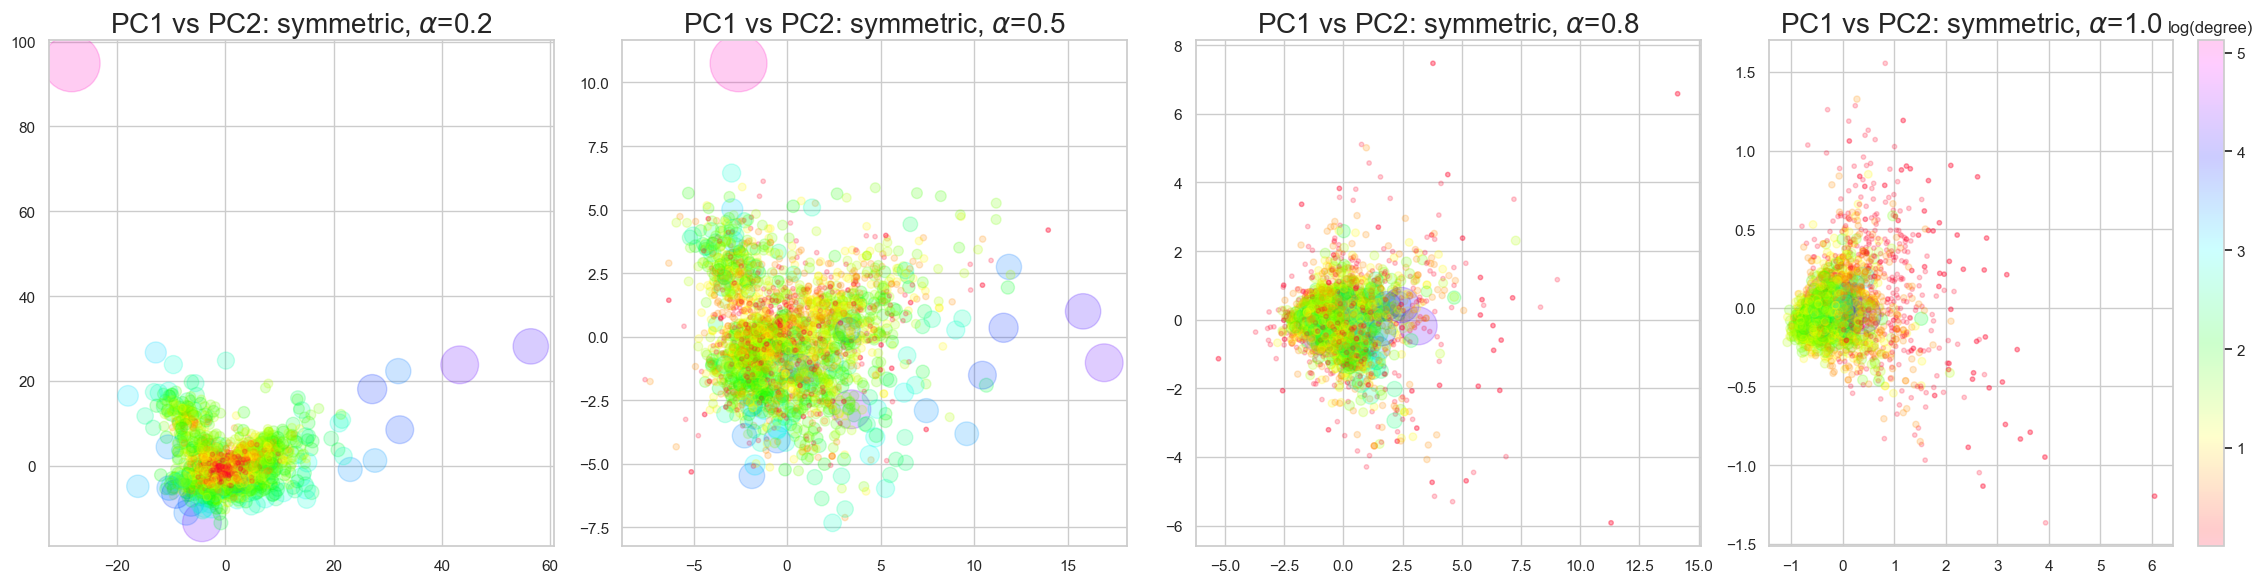

In [9]:
plot_embedding_transform_PCA(results, cora.edge_index, experiment = 'normal', alpha = [0.2,0.5,0.8,1.0], name = 'Cora', trial=1, loop = True, transparency =0.2)

## (c) Embedding Spaces -- node label

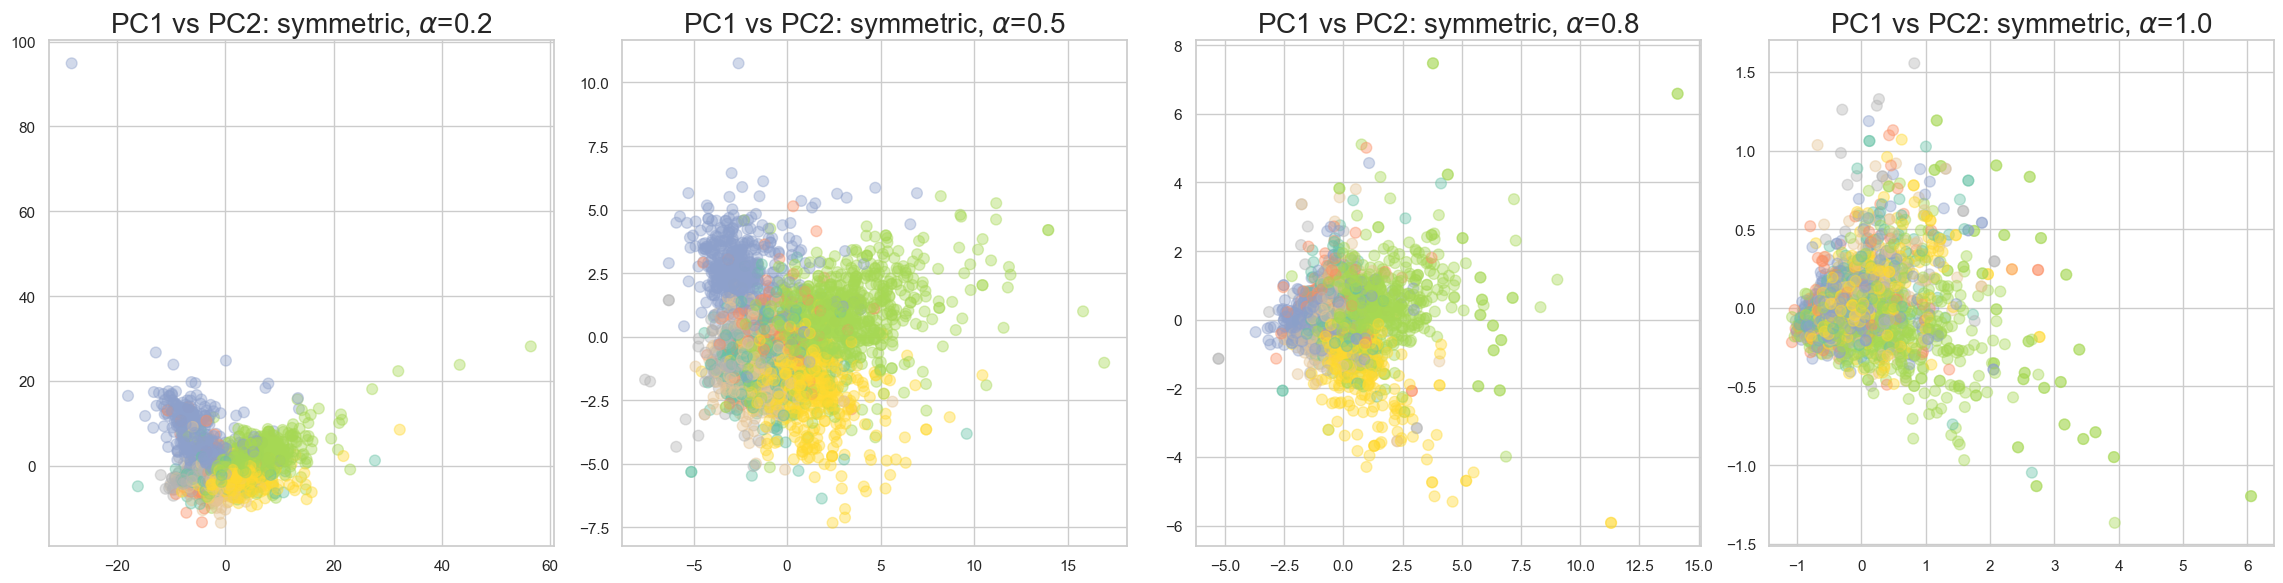

In [10]:
plot_embedding_class_PCA(results, cora, name = 'Cora', mult = 30)

## (d) Embedding Spaces -- curvature

/Users/sowonjeong/Documents/GitHub/GNN-Geometry/utils/visualization.py:199: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Adj = nx.adjacency_matrix(to_networkx(data)).todense()


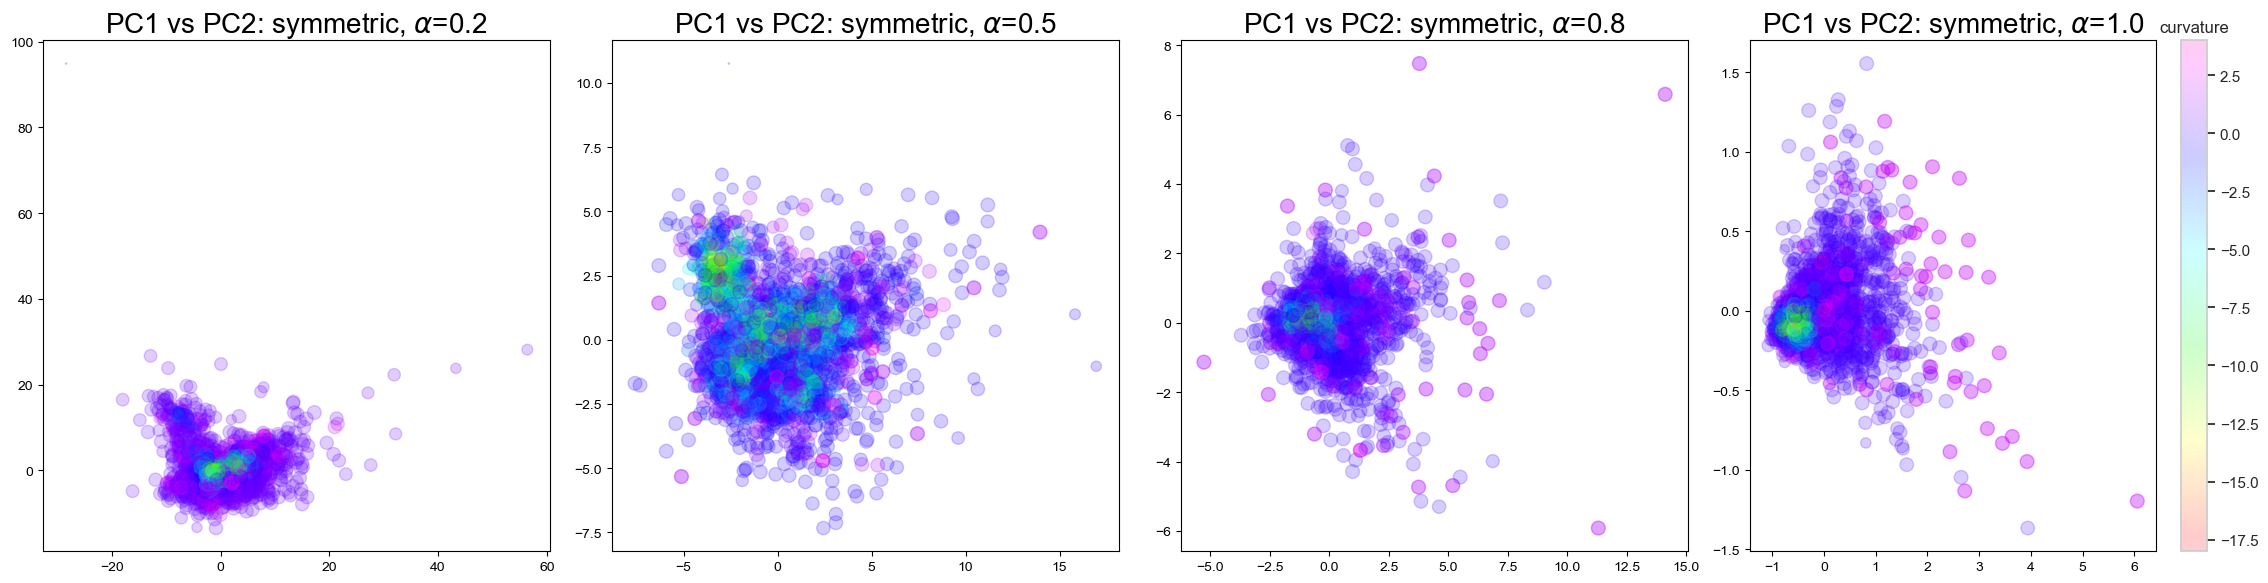

In [8]:
plot_embedding_curvature_PCA(results, cora, experiment = 'normal', transparency = 0.2)

# V. Correlations

## (a) Correlation between distances

In [9]:
from utils.correlation import *

In [10]:
d_cora =  dist_corr(data = cora, embedding = results, name = 'Cora')

NameError: name 'Tensor' is not defined

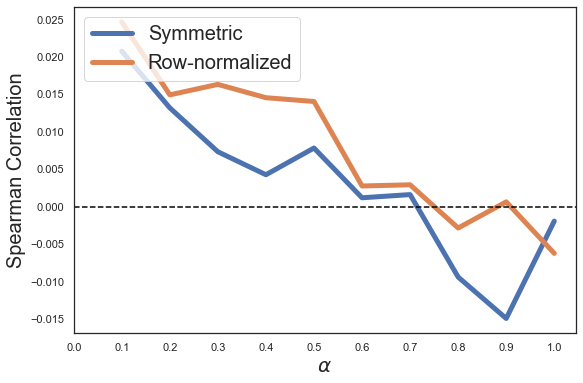

In [ ]:
draw_corr(d_cora, name = 'Cora',option ="graph" )

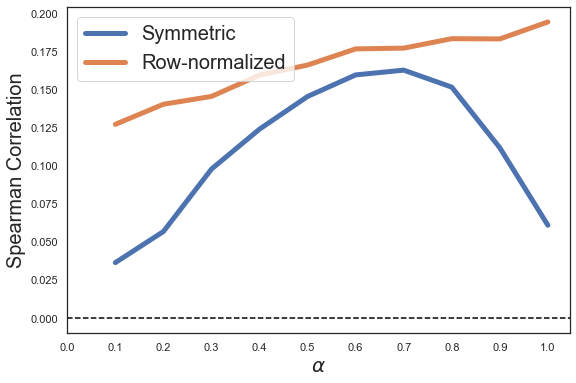

In [46]:
draw_corr(d_cora, name = 'Cora',option ="feature" )

## (b) Correlation between curvatures

In [54]:
def curv_corr(data, embedding, name = 'Cora', trial = 1, loop = True):
    F_embeddings  ={}
    alpha = np.arange(0,1.1,0.1)
    experiment = ["normal","diffusion"]
    Adj = nx.adjacency_matrix(to_networkx(data)).todense()
    F = augmented_forman(Adj)
    for i in range(2):
        for j in range(10):
            temp = embedding[name+'_'+experiment[i]+ '_' +str(alpha[j+1])+'_'+'loop'+'_'+str(loop)+'_'+str(trial)]['embedding']
            F1 = augmented_forman(pre_curvature(temp,data)).detach().numpy()
            F_embeddings[name+'_'+experiment[i]+ '_' +str(alpha[j+1])+'_'+'loop'+'_'+str(loop)+'_'+str(trial)] = {
                                                        'curvature' : F1, 
                                                         'corr_kt' : kendalltau(F,F1)[0],
                                                          'corr_sp' : spearmanr(F,F1)[0],
                                                          'corr_pr': pearsonr(F,F1)[0],
                'gnn_type' : experiment[i],
                'alpha' : alpha[j+1],
                'add_self_loop' : loop,
                'dataset' : name
                                                         }
    tab = pd.DataFrame.from_dict(F_embeddings).T
    tab.corr_sp = tab.corr_sp.astype('float')
    
    sns.set_theme(style="white", rc = {'figure.figsize':(9,6)})
    G = sns.lineplot(data = tab, x = 'alpha', y = 'corr_sp', hue = 'gnn_type', linewidth = 5)
    G.set_xticks(np.arange(0,1.1,0.1))
    G.axhline(0, ls='--', c = 'black')
    G.set_xticklabels = (['0',
                '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'])
    G.legend(labels = ['Symmetric','Row-normalized'],loc = 'upper left', fontsize =20)
    G.set_ylabel('Spearman Correlation', fontsize = 20)
    G.set_xlabel(r'$\alpha$', fontsize = 20)
    plt.show()

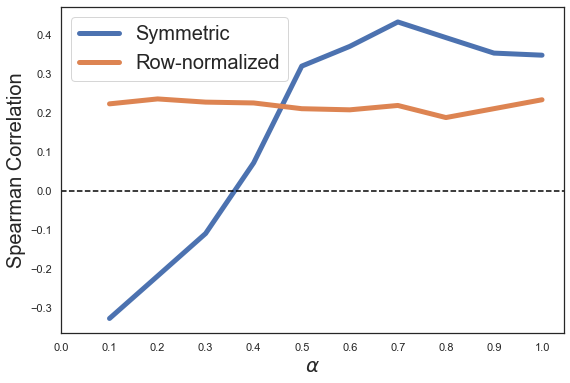

In [55]:
curv_corr(cora, results, 'Cora')